In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import matplotlib.colors as colors
from matplotlib import cm
%matplotlib inline

In [46]:
Nx = 5 #Resolution in x
Ny = 5 #Resolution in y
x_range = 20 #Range in x
y_range = 20 #Range in y

#Set up space
x = np.linspace(-x_range/2, x_range/2, Nx+1) #X values. Centered around origin
y = np.linspace(-y_range/2, y_range/2, Ny+1) #Y values. Centered around origin
xx, yy = np.meshgrid(x, y) #Pregenerate the meshgrid of points for all space we care about

print(xx)
print(np.roll(xx, 1, axis=1))
print(-2*xx)
print(np.roll(xx, 1, axis=1))

[[-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]
 [-10.  -6.  -2.   2.   6.  10.]]
[[ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]]
[[ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]
 [ 20.  12.   4.  -4. -12. -20.]]
[[ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]
 [ 10. -10.  -6.  -2.   2.   6.]]


In [85]:
def gaussian_2D(x, y, Lx, Ly):
    '''
    Gaussian peak at (Lx, Ly).

    Source: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py

    '''
    return np.exp(-5*(x-Lx)**2 - 5*(y-Ly)**2)

def gaussion_deriv(x, y, loc):
    # returns the initial time derivative of the wave --> u_t(x,0) = V(x)
    return v*(x-loc)*np.exp(-5*(x-Lx/2.0)**2 - 5*(y-Ly/2.0)**2)

def f(x, y, t):
    '''
    Driving function, but we don't want one right now.
    '''
    return np.zeros((t.size, *x.shape))

def reflecting_boundary_conditions(u):
    u[:, 0] = 0 #Left wall
    u[:,-1] = 0 #Right wall
    u[0, :] = 0 #Top wall
    u[-1,:] = 0 #Bottom wall
    return u

def propogate(xv, yv, dx, dy, Nt, c=1.0, courant_number=0.1, I=gaussian_2D, args=(0,0)):
    '''
    Propogates a wave through space using a vectorized finite differences method.
    
    WARNING: DON'T FORGET TO DEEP COPY.
    
    Params:
        xv - (1D array) X locations array
        yv - (1D array) Y locations array
        c - (float) Speed of light. Set to 1 usually cause physics and units.
    '''
    
    #*******Pre-computation*********
    
    states = np.empty((Nt, xv.shape[0], xv.shape[1]))
    
    #Initial conditions
    u = I(xv, yv, *args) #Initial values
    V_a = np.zeros(u.shape) #Initial velocities
    rho = np.ones(V_a.shape) #This might be tension, but not quite sure. Change it for fun.
    q = np.ones(V_a.shape)*c**2 #Velocities in space. Change this for refraction
    
    #CFL Condition. 
    #Velocity doesn't change through time, but it could through space
    #so find the maximum time step overall and precalculate.
    dt = np.min([courant_number/(q/dy), courant_number/(q/dx)])
    print("dt:", dt)
    
    #Now that we have the minimum time step, we can calculate the time range
    t = np.linspace(0, Nt*dt, Nt+1) 
    f_all = f(xv, yv, t)  #Driving function. Precompute at all time for efficiency
    
    #Everything needs to be squared anyways, so let's do it now
    dt2, dx2, dy2 = dt**2, dx**2, dy**2
    
    #*******Iteration*********
    
    #Calculate the first time step
    states[0, :, :] = u
    u[:, :] = vectorized_finite_differencing(u, u, dt, dt2, dx2, dy2, f_all[0], q, rho, V=V_a, first_step=True) #iterate
    u[:, :] = reflecting_boundary_conditions(u) #reset boundaries
    
    #Continue with recursive algorithm once enough points are calculated.
    for i in range(1, Nt):
        u[:, :] = vectorized_finite_differencing(u, states[i-1], dt, dt2, dx2, dy2, f_all[i], q, rho) #iterate
        u[:, :] = reflecting_boundary_conditions(u) #reset boundaries
        states[i, :, :] = u
    
    return states

def vectorized_finite_differencing(u_current, u_previous, dt, dt2, dx2, dy2, driving_fn, q, rho, V=None, first_step=False):
    '''
    An implementation of a 2D finite differencing algorithm for 
    the wave equation. Implemented using numpy vector manipulation
    instead of iteration for speed.
    
    Reference: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py
               http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/html/slides_wave-solarized.html#wave:2D3D
    Params:
        u_current - (2D array) Grid of solutions at n
        u_last - (2D array) Grid of solutions at n-1
        dt - (float) Time step for this iteration
        fn - (2D array) Driving function, precalculated and in array format
        q - (2D array) Speed coefficient
        rho - (2D array) 
    Returns:
        u - (2D array) Grid of solutions at time step n+1
    ''' 
    
    # This does NOT implement a Neumann condition. This abuses python's convenient wraparound indexing,
    # which is fine as long as we don't hit the edge, or we only want to do reflection anyways.
    u_xx = (np.roll(q, 1, axis=1)+q)*(np.roll(u_current, 1, axis=1) - u_current) - (q+np.roll(q, -1, axis=1))*(np.roll(u_current, -1, axis=1) - u_current)
    #u_yy = (q+np.roll(q, 1, axis=0))*(np.roll(u_current, 1, axis=0) - u_current) - (q+np.roll(q, -1, axis=0))*(np.roll(u_current, -1, axis=0) - u_current)
    #u_xx = (np.roll(u_current, 1, axis=1)-2*u_current+np.roll(u_current, 1, axis=1))
    #u_yy = (np.roll(u_current, 1, axis=0)-2*u_current+np.roll(u_current, 1, axis=0))
    
    #print(np.sum(u_xx), np.sum(u_yy), np.sum((q+np.roll(q, 1, axis=0))*(np.roll(u_current, 1, axis=0) - u_current)))
    #print(np.sum(np.roll(u_current, 1, axis=0)), u_current)
    
    
    #Different equation for the first time step to rectify the recursive negative time problem. 
    #if first_step: return u_current - dt*V + (dt**2)*((u_xx/dx**2 + u_yy/dy**2)/(4*rho) + driving_fn[i]/2)
    if first_step: return u_current - dt*V + q*dt2*(u_xx/dx2 )/4 #+ q*dt2*(u_xx/dx2 + u_yy/dy2 )/2
    
    #print(np.roll(u_current, 1, axis=0) - u_current)
    #print("Change:", np.round(dt2*(u_xx + u_yy)/2, 4))
    
    #return 2*u_current - u_last + (dt**2)*((u_xx/dx**2 + u_yy/dy**2)/(4*rho) + driving_fn[i]/2)
    return 2*u_current - u_previous + q*dt2*(u_xx/dx2 )/2 #+ q*dt2*(u_xx/dx2 + u_yy/dy2 )/2

In [90]:
Nx = 200 #Resolution in x
Ny = 200 #Resolution in y
Nt = 6000 #Resolution in time
x_range = 10 #Range in x
y_range = 10 #Range in y

#Set up space
x = np.linspace(-x_range/2, x_range/2, Nx+1) #X values. Centered around origin
y = np.linspace(-y_range/2, y_range/2, Ny+1) #Y values. Centered around origin

dx = x[1] - x[0] #Change in x. Constant across mesh for simplicity.
dy = y[1] - y[0] #Change in y. Constant across mesh for simplicity.

xx, yy = np.meshgrid(x, y) #Pre-generate the meshgrid of points for all space we care about

print("dx:", dx, "| dy:", dy)

#Runs finite differences for the parameters above.
things = propogate(xx, yy, dx, dy, Nt)

#**************Plotting & Stuff***************
plotting = False
printing = False

if plotting:
    initial_values = gaussian_2D(xx, yy, 0, 0)

    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(7, 7)
    surface = ax.plot_surface(xx, yy, initial_values,
                            facecolors=cm.jet(initial_values), shade=False)
    surface.set_facecolor((0,0,0,0))
    plt.show()


for i, thing in enumerate(things):
    if printing: print("Iteration:", i, " | Energy:", np.sum(thing), " | Maximum value:", thing.max())
    
    if (i%15==0) and plotting:
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        fig.set_size_inches(7, 7)
        surface = ax.plot_surface(xx, yy, thing,
                                facecolors=cm.jet(thing), shade=False)
        surface.set_facecolor((0,0,0,0))
        ax.set_zlim(0, 1)
        plt.show()
        
        plt.plot(x, thing[len(t)//2])
        plt.show()

dx: 0.05 | dy: 0.05
dt: 0.005


<IPython.core.display.Javascript object>


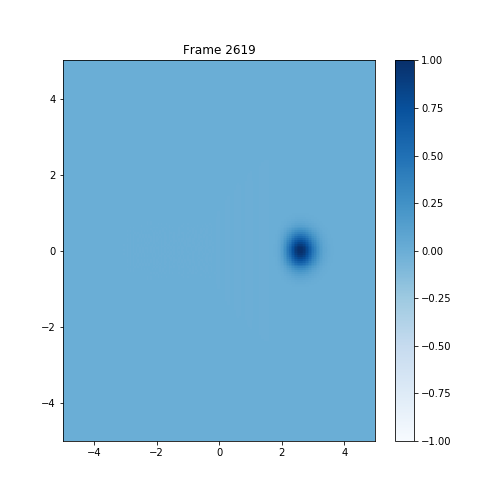

In [93]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(x, y, things[0],
                    vmin=-1, vmax=1, cmap='Blues')
fig.colorbar(cax)
fig.set_size_inches(7, 7)
ax.set_title("Frame 0")

def animate_colourmesh(i, things, cax, ax):
    cax.set_array(np.ravel(things[i, :-1, :-1]))
    ax.set_title("Frame "+str(i))
    return cax,

line_ani = animation.FuncAnimation(fig, animate_colourmesh, Nt, fargs=(things, cax, ax),
                                   interval=1, blit=True);

# For windows machine:
saving = False
if saving:
    plt.rcParams['animation.ffmpeg_path'] = 'D:\\Downloads\\ffmpeg-20180227-fa0c9d6-win64-static\\ffmpeg-20180227-fa0c9d6-win64-static\\bin\\ffmpeg.exe'
    FFwriter = animation.FFMpegWriter(fps=60)
    print("Saving")
    line_ani.save('wave_equation_animation_colormap.mp4', writer=FFwriter, dpi=100)
    print("Saved")

Traceback (most recent call last):
  File "D:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


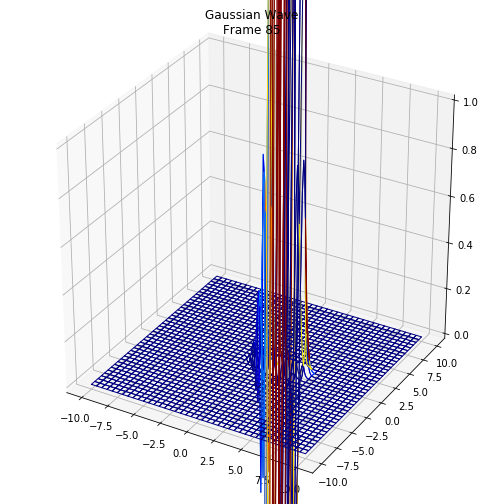

In [58]:
%matplotlib notebook
%matplotlib notebook

def generate_plot_object(xx, yy, data):
    '''
    A function to generate the lines for a plot to be animated, initialised with the first
    nodes in the data array.
    '''
    #Source: https://matplotlib.org/examples/animation/simple_3danim.html
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(7, 7)
    
    surface = ax.plot_surface(xx, yy, data[0], rcount=20, ccount=20,
                            facecolors=cm.jet(data[0]), shade=False)
    surface.set_facecolor((0,0,0,0))
    
    # Setting the axes properties
    ax.set_xlim3d([-x_range/2, x_range/2])
    ax.set_xlabel('X')

    ax.set_ylim3d([-y_range/2, y_range/2])
    ax.set_ylabel('Y')

    ax.set_zlim3d([0.0, 1.0])
    ax.set_zlabel('Z')

    ax.set_title('Gaussian Wave\nFrame 0')
    #fig.colorbar()
    
    return fig, ax, surface

def animate_wireframe(num, data, ax):
    ax.clear()
    ax.set_zlim(0, 1)
    ax.set_title('Gaussian Wave\nFrame ' + str(num))

    surface = ax.plot_surface(xx, yy, data[num],
                            facecolors=cm.jet(data[num]), shade=False)
    surface.set_facecolor((0,0,0,0))

    return surface,

fig, ax, surfaces = generate_plot_object(xx, yy, things)

line_ani = animation.FuncAnimation(fig, animate_wireframe, Nt, fargs=(things, ax),
                                   interval=1, blit=True);

# For a mac (sorta, needs to be modified a little bit):
# Uncomment these lines to save the animation. 
# Please make sure that you download ffmpeg and then set the pointer to the correct location for your system
#plt.rcParams['animation.ffmpeg_path'] = '/home/nathan.meulenbroek/miniconda3/bin'
#line_ani.save('lorentz_system.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# For windows machine:
saving = False
if saving:
    plt.rcParams['animation.ffmpeg_path'] = 'D:\\Downloads\\ffmpeg-20180227-fa0c9d6-win64-static\\ffmpeg-20180227-fa0c9d6-win64-static\\bin\\ffmpeg.exe'
    FFwriter = animation.FFMpegWriter(fps=60)
    print("Saving")
    line_ani.save('wave_equation_animation_wireframe.mp4', writer=FFwriter, dpi=100)
    print("Saved")

In [ ]:
#!/usr/bin/env python
"""
2D wave equation solved by finite differences::
  dt, cpu_time = solver(I, V, f, c, Lx, Ly, Nx, Ny, dt, T,
                        user_action=None, version='scalar',
                        stability_safety_factor=1)
Solve the 2D wave equation u_tt = u_xx + u_yy + f(x,t) on (0,L) with
u=0 on the boundary and initial condition du/dt=0.
Nx and Ny are the total number of mesh cells in the x and y
directions. The mesh points are numbered as (0,0), (1,0), (2,0),
..., (Nx,0), (0,1), (1,1), ..., (Nx, Ny).
dt is the time step. If dt<=0, an optimal time step is used.
T is the stop time for the simulation.
I, V, f are functions: I(x,y), V(x,y), f(x,y,t). V and f
can be specified as None or 0, resulting in V=0 and f=0.
user_action: function of (u, x, y, t, n) called at each time
level (x and y are one-dimensional coordinate vectors).
This function allows the calling code to plot the solution,
compute errors, etc.
"""
import time, sys

def solver(I, V, f, c, Lx, Ly, Nx, Ny, dt, T,
           user_action=None, version='scalar'):
    if version == 'vectorized':
        advance = advance_vectorized
    elif version == 'scalar':
        advance = advance_scalar

    x = np.linspace(0, Lx, Nx+1)  # Mesh points in x dir
    y = np.linspace(0, Ly, Ny+1)  # Mesh points in y dir
    # Make sure dx, dy, and dt are compatible with x, y and t
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dt = 1e-2

    xv = x[:,np.newaxis]          # For vectorized function evaluations
    yv = y[np.newaxis,:]

    stability_limit = (1/float(c))*(1/np.sqrt(1/dx**2 + 1/dy**2))
    if dt <= 0:                # max time step?
        safety_factor = -dt    # use negative dt as safety factor
        dt = safety_factor*stability_limit
    elif dt > stability_limit:
        print('error: dt=%g exceeds the stability limit %g' % \
              (dt, stability_limit))
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)    # mesh points in time
    Cx2 = (c*dt/dx)**2;  Cy2 = (c*dt/dy)**2    # help variables
    dt2 = dt**2

    # Allow f and V to be None or 0
    if f is None or f == 0:
        f = (lambda x, y, t: 0) if version == 'scalar' else \
            lambda x, y, t: np.zeros((x.shape[0], y.shape[1]))
        # or simpler: x*y*0
    if V is None or V == 0:
        V = (lambda x, y: 0) if version == 'scalar' else \
            lambda x, y: np.zeros((x.shape[0], y.shape[1]))


    order = 'Fortran' if version == 'f77' else 'C'
    u     = np.zeros((Nx+1,Ny+1), order=order)   # Solution array
    u_n   = np.zeros((Nx+1,Ny+1), order=order)   # Solution at t-dt
    u_nm1 = np.zeros((Nx+1,Ny+1), order=order)   # Solution at t-2*dt
    f_a   = np.zeros((Nx+1,Ny+1), order=order)   # For compiled loops

    Ix = range(0, u.shape[0])
    Iy = range(0, u.shape[1])
    It = range(0, t.shape[0])

    import time; t0 = time.clock()  # For measuring CPU time

    # Load initial condition into u_n
    if version == 'scalar':
        for i in Ix:
            for j in Iy:
                u_n[i,j] = I(x[i], y[j])
    else:
        # Use vectorized version (requires I to be vectorized)
        u_n[:,:] = I(xv, yv)

    if user_action is not None:
        user_action(u_n, x, xv, y, yv, t, 0)

    # Special formula for first time step
    n = 0
    # First step requires a special formula, use either the scalar
    # or vectorized version (the impact of more efficient loops than
    # in advance_vectorized is small as this is only one step)
    if version == 'scalar':
        u = advance_scalar(
            u, u_n, u_nm1, f, x, y, t, n,
            Cx2, Cy2, dt2, V, step1=True)

    else:
        f_a[:,:] = f(xv, yv, t[n])  # precompute, size as u
        V_a = V(xv, yv)
        u = advance_vectorized(
            u, u_n, u_nm1, f_a,
            Cx2, Cy2, dt2, V=V_a, step1=True)

    if user_action is not None:
        user_action(u, x, xv, y, yv, t, 1)

    # Update data structures for next step
    #u_nm1[:] = u_n;  u_n[:] = u  # safe, but slow
    u_nm1, u_n, u = u_n, u, u_nm1

    for n in It[1:-1]:
        if version == 'scalar':
            # use f(x,y,t) function
            u = advance(u, u_n, u_nm1, f, x, y, t, n, Cx2, Cy2, dt2)
        else:
            f_a[:,:] = f(xv, yv, t[n])  # precompute, size as u
            u = advance(u, u_n, u_nm1, f_a, Cx2, Cy2, dt2)

        if user_action is not None:
            if user_action(u, x, xv, y, yv, t, n+1):
                break

        # Update data structures for next step
        u_nm1, u_n, u = u_n, u, u_nm1

    # Important to set u = u_n if u is to be returned!
    t1 = time.clock()
    # dt might be computed in this function so return the value
    return dt, t1 - t0



def advance_scalar(u, u_n, u_nm1, f, x, y, t, n, Cx2, Cy2, dt2,
                   V=None, step1=False):
    Ix = range(0, u.shape[0]);  Iy = range(0, u.shape[1])
    if step1:
        dt = sqrt(dt2)  # save
        Cx2 = 0.5*Cx2;  Cy2 = 0.5*Cy2; dt2 = 0.5*dt2  # redefine
        D1 = 1;  D2 = 0
    else:
        D1 = 2;  D2 = 1
    for i in Ix[1:-1]:
        for j in Iy[1:-1]:
            u_xx = u_n[i-1,j] - 2*u_n[i,j] + u_n[i+1,j]
            u_yy = u_n[i,j-1] - 2*u_n[i,j] + u_n[i,j+1]
            u[i,j] = D1*u_n[i,j] - D2*u_nm1[i,j] + \
                     Cx2*u_xx + Cy2*u_yy + dt2*f(x[i], y[j], t[n])
            if step1:
                u[i,j] += dt*V(x[i], y[j])
    # Boundary condition u=0
    j = Iy[0]
    for i in Ix: u[i,j] = 0
    j = Iy[-1]
    for i in Ix: u[i,j] = 0
    i = Ix[0]
    for j in Iy: u[i,j] = 0
    i = Ix[-1]
    for j in Iy: u[i,j] = 0
    return u

def advance_vectorized(u, u_n, u_nm1, f_a, Cx2, Cy2, dt2,
                       V=None, step1=False):
    if step1:
        dt = sqrt(dt2)  # save
        Cx2 = 0.5*Cx2;  Cy2 = 0.5*Cy2; dt2 = 0.5*dt2  # redefine
        D1 = 1;  D2 = 0
    else:
        D1 = 2;  D2 = 1
    u_xx = u_n[:-2,1:-1] - 2*u_n[1:-1,1:-1] + u_n[2:,1:-1]
    u_yy = u_n[1:-1,:-2] - 2*u_n[1:-1,1:-1] + u_n[1:-1,2:]
    u[1:-1,1:-1] = D1*u_n[1:-1,1:-1] - D2*u_nm1[1:-1,1:-1] + \
                   Cx2*u_xx + Cy2*u_yy + dt2*f_a[1:-1,1:-1]
    if step1:
        u[1:-1,1:-1] += dt*V[1:-1, 1:-1]
    # Boundary condition u=0
    j = 0
    u[:,j] = 0
    j = u.shape[1]-1
    u[:,j] = 0
    i = 0
    u[i,:] = 0
    i = u.shape[0]-1
    u[i,:] = 0
    return u

def quadratic(Nx, Ny, version):
    """Exact discrete solution of the scheme."""

    def exact_solution(x, y, t):
        return x*(Lx - x)*y*(Ly - y)*(1 + 0.5*t)

    def I(x, y):
        return exact_solution(x, y, 0)

    def V(x, y):
        return 0.5*exact_solution(x, y, 0)

    def f(x, y, t):
        return 2*c**2*(1 + 0.5*t)*(y*(Ly - y) + x*(Lx - x))

    Lx = 5;  Ly = 2
    c = 1.5
    dt = -1 # use longest possible steps
    T = 18

    def assert_no_error(u, x, xv, y, yv, t, n):
        u_e = exact_solution(xv, yv, t[n])
        diff = abs(u - u_e).max()
        tol = 1E-12
        msg = 'diff=%g, step %d, time=%g' % (diff, n, t[n])
        assert diff < tol, msg

    new_dt, cpu = solver(
        I, V, f, c, Lx, Ly, Nx, Ny, dt, T,
        user_action=assert_no_error, version=version)
    return new_dt, cpu


def test_quadratic():
    # Test a series of meshes where Nx > Ny and Nx < Ny
    versions = 'scalar', 'vectorized', 'cython', 'f77', 'c_cy', 'c_f2py'
    for Nx in range(2, 6, 2):
        for Ny in range(2, 6, 2):
            for version in versions:
                print('testing', version, 'for %dx%d mesh' % (Nx, Ny))
                quadratic(Nx, Ny, version)

def run_efficiency(nrefinements=4):
    def I(x, y):
        return sin(pi*x/Lx)*sin(pi*y/Ly)

    Lx = 10;  Ly = 10
    c = 1.5
    T = 100
    versions = ['scalar', 'vectorized', 'cython', 'f77',
               'c_f2py', 'c_cy']
    print(' '*15, ''.join(['%-13s' % v for v in versions]))
    for Nx in 15, 30, 60, 120:
        cpu = {}
        for version in versions:
            dt, cpu_ = solver(I, None, None, c, Lx, Ly, Nx, Nx,
                              -1, T, user_action=None,
                              version=version)
            cpu[version] = cpu_
        cpu_min = min(list(cpu.values()))
        if cpu_min < 1E-6:
            print('Ignored %dx%d grid (too small execution time)' \
                  % (Nx, Nx))
        else:
            cpu = {version: cpu[version]/cpu_min for version in cpu}
            print('%-15s' % '%dx%d' % (Nx, Nx))
            print(''.join(['%13.1f' % cpu[version] for version in versions]))

def gaussian(plot_method=3, version='vectorized', save_plot=True):
    """
    Initial Gaussian bell in the middle of the domain.
    plot_method=1 applies mesh function, =2 means surf, =0 means no plot.
    """

    Lx = 10
    Ly = 10
    c = 1.0

    def I(x, y):
        """Gaussian peak at (Lx/2, Ly/2)."""
        return np.exp(-0.5*(x-Lx/2.0)**2 - 0.5*(y-Ly/2.0)**2)

    if plot_method == 3:
        from mpl_toolkits.mplot3d import axes3d
        import matplotlib.pyplot as plt
        from matplotlib import cm
        plt.ion()
        fig = plt.figure()
        u_surf = None

    def plot_u(u, x, xv, y, yv, t, n):
        if t[n] == 0:
            time.sleep(2)
        if plot_method == 1:
            mesh(x, y, u, title='t=%g' % t[n], zlim=[-1,1],
                 caxis=[-1,1])
        elif plot_method == 2:
            surfc(xv, yv, u, title='t=%g' % t[n], zlim=[-1, 1],
                  colorbar=True, colormap=hot(), caxis=[-1,1],
                  shading='flat')
        elif plot_method == 3:
            print('Experimental 3D matplotlib...under development...')
            #plt.clf()
            ax = fig.add_subplot(111, projection='3d')
            u_surf = ax.plot_surface(xv, yv, u, alpha=0.3)
            #ax.contourf(xv, yv, u, zdir='z', offset=-100, cmap=cm.coolwarm)
            #ax.set_zlim(-1, 1)
            # Remove old surface before drawing
            if u_surf is not None:
                ax.collections.remove(u_surf)
            plt.draw()
            time.sleep(1)
        if plot_method > 0:
            time.sleep(0) # pause between frames
            if save_plot:
                filename = 'tmp_%04d.png' % n
                savefig(filename)  # time consuming!

    Nx = 40; Ny = 40; T = 20
    dt, cpu = solver(I, None, None, c, Lx, Ly, Nx, Ny, -1, T,
                     user_action=plot_u, version=version)



if __name__ == '__main__':
    gaussian()